# Brain Tumor Classification - Model Comparison

This notebook compares the baseline model explored in the previous section with more advanced models including using residual connections, and using Vision Transformers.

## 1. Setup and Imports

In [ ]:
#!/usr/bin/env python
# coding: utf-8
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
import matplotlib.pyplot as plt
import timm
import time

In [ ]:
# # import our own modules
# import sys
# sys.path.append('../src')  # Add the src directory to the Python path

from google.colab import drive
drive.mount('/content/gdrive')

# Use os.path.join to avoid manual path issues
path = os.path.join('gdrive', 'My Drive', 'Erdos', 'brainnet-medical-imaging', 'src')

# Change directory
# os.getcwd()
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import data
from config.data import data_setup, data_loader
from models.vision_transformer import run_training
from utils.prediction import analyze_predictions, train_model
from models.cnn import BrainTumorCNN, BrainTumorCNN_RN
from utils.visualization import plot_epoch_times, train_model, plot_accuracy_results

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda
Using device: cuda
Using device: cuda


## 2. Data Loading and Preprocessing

In [ ]:
# Load data and data_loaders
train_set, test_set, label_conversion_dict = data_setup()
train_loader, test_loader = data_loader(train_set, test_set)

# Extract the class labels from the dictionary keys
class_labels = list(label_conversion_dict.keys())[:4]

/content/gdrive/My Drive/Erdos/brainnet-medical-imaging/src/config/data.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['label'] = df_unique['filepath'].apply(lambda x: x.split('/')[-2])
/content/gdrive/My Drive/Erdos/brainnet-medical-imaging/src/config/data.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['class'] = df_unique['filename'].apply(lambda x: 'train' if x[:2] == 'Tr' else 'test')
100%|██████████| 6726/6726 [00:04<00:00, 1518.41it/s]


Initial number of samples in train set: 5521
Initial number of samples in test set: 1205
Total samples in train set after overriding labels: 5521
Total samples in test set after overriding labels: 1205
Total files in train set: 5521, with target values: [0, 1, 2, 3]
Total files in test set: 1205, with target values: [0, 1, 2, 3]


# 3. Model training

We start with our baseline model

In [ ]:
# Initialize model
model_cnn = BrainTumorCNN().to(device)
print(model_cnn)

BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

Epoch 1/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/10:
Train Loss: 0.7087, Val Loss: 0.5216, Accuracy: 77.76%


Epoch 2/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/10:
Train Loss: 0.4212, Val Loss: 0.3971, Accuracy: 83.40%


Epoch 3/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/10:
Train Loss: 0.3284, Val Loss: 0.3593, Accuracy: 85.98%


Epoch 4/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/10:
Train Loss: 0.2549, Val Loss: 0.3448, Accuracy: 86.80%


Epoch 5/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/10:
Train Loss: 0.2173, Val Loss: 0.4008, Accuracy: 84.65%


Epoch 6/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6/10:
Train Loss: 0.1699, Val Loss: 0.3853, Accuracy: 84.65%


Epoch 7/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7/10:
Train Loss: 0.1341, Val Loss: 0.2582, Accuracy: 90.71%


Epoch 8/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8/10:
Train Loss: 0.1058, Val Loss: 0.1883, Accuracy: 93.53%


Epoch 9/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 9/10:
Train Loss: 0.0943, Val Loss: 0.2969, Accuracy: 89.88%


Epoch 10/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10/10:
Train Loss: 0.0942, Val Loss: 0.3109, Accuracy: 90.12%


In [ ]:
history = train_model(
    model=model_cnn,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10
)

# Now you can access the following:
cnn_train_loss_list = history['train_loss_list']
cnn_test_loss_list = history['test_loss_list']
cnn_accuracy_list = history['accuracy_list']
cnn_all_predictions = history['all_predictions']
cnn_all_true_labels = history['all_true_labels']

In [ ]:
# Print the mean of the epoch times
cnn_epoch_times = history['epoch_times']
print(f"CNN mean epoch time: {np.mean(cnn_epoch_times):.2f} seconds")

Epoch 1 Prediction Counts: Counter({np.int64(3): 372, np.int64(0): 334, np.int64(2): 268, np.int64(1): 231})
Epoch 2 Prediction Counts: Counter({np.int64(1): 352, np.int64(2): 321, np.int64(3): 287, np.int64(0): 245})
Epoch 3 Prediction Counts: Counter({np.int64(2): 375, np.int64(3): 296, np.int64(1): 281, np.int64(0): 253})
Epoch 4 Prediction Counts: Counter({np.int64(2): 366, np.int64(1): 321, np.int64(3): 304, np.int64(0): 214})
Epoch 5 Prediction Counts: Counter({np.int64(2): 391, np.int64(0): 371, np.int64(3): 272, np.int64(1): 171})
Epoch 6 Prediction Counts: Counter({np.int64(1): 408, np.int64(2): 331, np.int64(3): 259, np.int64(0): 207})
Epoch 7 Prediction Counts: Counter({np.int64(2): 342, np.int64(3): 317, np.int64(1): 310, np.int64(0): 236})
Epoch 8 Prediction Counts: Counter({np.int64(1): 330, np.int64(2): 313, np.int64(3): 311, np.int64(0): 251})
Epoch 9 Prediction Counts: Counter({np.int64(1): 402, np.int64(2): 317, np.int64(0): 246, np.int64(3): 240})
Epoch 10 Prediction

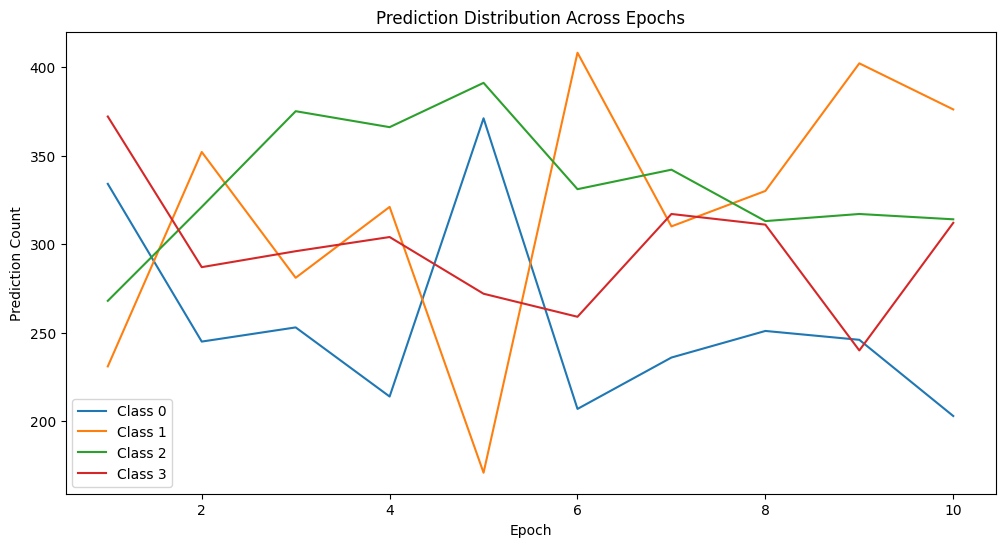


Overall Prediction Counts Across All Epochs: Counter({np.int64(2): 3338, np.int64(1): 3182, np.int64(3): 2970, np.int64(0): 2560})
Overall Accuracy Across All Epochs: 86.75%
All results have been successfully saved in the 'results/' directory.


In [ ]:
# Analyse and save predictions
analyze_predictions(cnn_all_predictions, cnn_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/cnn_train_loss_list.npy', np.array(cnn_train_loss_list))
np.save('results/cnn_test_loss_list.npy', np.array(cnn_test_loss_list))
np.save('results/cnn_accuracy_list.npy', np.array(cnn_accuracy_list))
np.save('results/cnn_epoch_times_list.npy', np.array(cnn_epoch_times))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/cnn_all_predictions.pkl', 'wb') as f:
    pickle.dump(cnn_all_predictions, f)

with open('results/cnn_all_true_labels.pkl', 'wb') as f:
    pickle.dump(cnn_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")


Now we try the same CNN but with residual connections.

In [ ]:
model_cnn_res = BrainTumorCNN_RN().to(device)
print(model_cnn_res)

BrainTumorCNN_RN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0)

Epoch 1/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/10:
Train Loss: 0.8794, Val Loss: 0.5660, Accuracy: 76.93%


Epoch 2/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/10:
Train Loss: 0.4147, Val Loss: 0.4824, Accuracy: 79.34%


Epoch 3/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/10:
Train Loss: 0.3397, Val Loss: 0.5015, Accuracy: 81.66%


Epoch 4/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/10:
Train Loss: 0.2950, Val Loss: 0.3506, Accuracy: 85.39%


Epoch 5/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/10:
Train Loss: 0.2454, Val Loss: 0.4080, Accuracy: 83.49%


Epoch 6/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6/10:
Train Loss: 0.2021, Val Loss: 0.5068, Accuracy: 80.08%


Epoch 7/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7/10:
Train Loss: 0.1847, Val Loss: 0.3231, Accuracy: 87.55%


Epoch 8/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8/10:
Train Loss: 0.1778, Val Loss: 0.2747, Accuracy: 88.55%


Epoch 9/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 9/10:
Train Loss: 0.1616, Val Loss: 0.3640, Accuracy: 86.89%


Epoch 10/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10/10:
Train Loss: 0.1458, Val Loss: 0.2078, Accuracy: 92.28%


In [ ]:
history = train_model(
    model=model_cnn_res,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10
)

In [ ]:
# Now you can access the following:
cnn_res_train_loss_list = history['train_loss_list']
cnn_res_test_loss_list = history['test_loss_list']
cnn_res_accuracy_list = history['accuracy_list']
cnn_res_all_predictions = history['all_predictions']
cnn_res_all_true_labels = history['all_true_labels']

# Print the mean of the epoch times
cnn_res_epoch_times = history['epoch_times']
print(f"CNN (Res) mean epoch time: {np.mean(cnn_res_epoch_times):.2f} seconds")

Epoch 1 Prediction Counts: Counter({np.int64(2): 392, np.int64(1): 290, np.int64(3): 288, np.int64(0): 235})
Epoch 2 Prediction Counts: Counter({np.int64(2): 404, np.int64(3): 323, np.int64(0): 311, np.int64(1): 167})
Epoch 3 Prediction Counts: Counter({np.int64(0): 377, np.int64(2): 373, np.int64(3): 288, np.int64(1): 167})
Epoch 4 Prediction Counts: Counter({np.int64(2): 329, np.int64(3): 326, np.int64(1): 286, np.int64(0): 264})
Epoch 5 Prediction Counts: Counter({np.int64(1): 398, np.int64(2): 327, np.int64(3): 324, np.int64(0): 156})
Epoch 6 Prediction Counts: Counter({np.int64(0): 434, np.int64(2): 373, np.int64(3): 274, np.int64(1): 124})
Epoch 7 Prediction Counts: Counter({np.int64(2): 383, np.int64(3): 333, np.int64(0): 271, np.int64(1): 218})
Epoch 8 Prediction Counts: Counter({np.int64(2): 357, np.int64(0): 346, np.int64(3): 304, np.int64(1): 198})
Epoch 9 Prediction Counts: Counter({np.int64(1): 415, np.int64(2): 274, np.int64(3): 273, np.int64(0): 243})
Epoch 10 Prediction

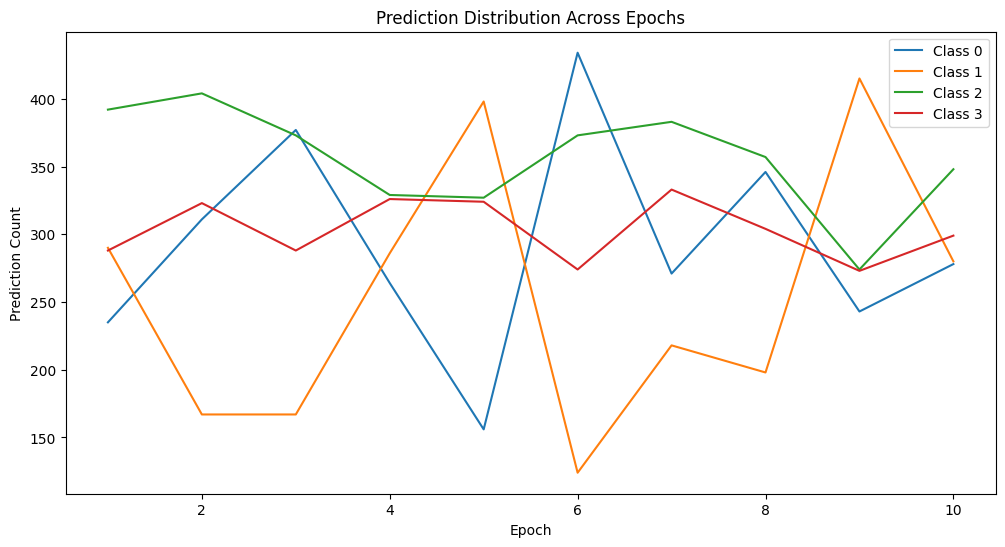


Overall Prediction Counts Across All Epochs: Counter({np.int64(2): 3560, np.int64(3): 3032, np.int64(0): 2915, np.int64(1): 2543})
Overall Accuracy Across All Epochs: 84.22%
All results have been successfully saved in the 'results/' directory.


In [ ]:
# Analyse and save predictions
analyze_predictions(cnn_res_all_predictions, cnn_res_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/cnn_res_train_loss_list.npy', np.array(cnn_res_train_loss_list))
np.save('results/cnn_res_test_loss_list.npy', np.array(cnn_res_test_loss_list))
np.save('results/cnn_res_accuracy_list.npy', np.array(cnn_res_accuracy_list))
np.save('results/cnn_res_epoch_times_list.npy', np.array(cnn_res_epoch_times))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/cnn_res_all_predictions.pkl', 'wb') as f:
    pickle.dump(cnn_res_all_predictions, f)

with open('results/cnn_res_all_true_labels.pkl', 'wb') as f:
    pickle.dump(cnn_res_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")


We use a pre-trained ViT, else we would overfit the data since ViT need a lot of data and we only have a few thousand images

In [ ]:
# Load a pre-trained Vision Transformer model
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)  # Adjust 'num_classes' to your task
vit_model.to(device)
vit_model.train()  # Set model to training mode

# Print the model architecture
print(vit_model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
train_set_vit, test_set_vit, label_conversion_dict = data_setup(vision_transformer=True)
train_loader_vit, test_loader_vit = data_loader(train_set_vit, test_set_vit)

/content/gdrive/My Drive/Erdos/brainnet-medical-imaging/src/config/data.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['label'] = df_unique['filepath'].apply(lambda x: x.split('/')[-2])
/content/gdrive/My Drive/Erdos/brainnet-medical-imaging/src/config/data.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['class'] = df_unique['filename'].apply(lambda x: 'train' if x[:2] == 'Tr' else 'test')
100%|██████████| 6726/6726 [00:04<00:00, 1622.59it/s]


Initial number of samples in train set: 5521
Initial number of samples in test set: 1205
Total samples in train set after overriding labels: 5521
Total samples in test set after overriding labels: 1205
Total files in train set: 5521, with target values: [0, 1, 2, 3]
Total files in test set: 1205, with target values: [0, 1, 2, 3]


In [ ]:
# Standard optimizer setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

# Set number of epochs
num_epochs = 5

# Run training
train_loss_list, test_loss_list, accuracy_list, vit_all_predictions, vit_all_true_labels, vit_epoch_times = run_training(
    vit_model, train_loader_vit, test_loader_vit, optimizer, None, criterion, num_epochs, device, fine_tuning=False
)

# Print the mean epoch time
vit_mean_epoch_time = np.mean(vit_epoch_times)
print(f"ViT mean epoch time: {vit_mean_epoch_time:.2f} seconds")

Epoch [1/5], Train Loss: 1.7682, Val Loss: 1.1511, Accuracy: 48.30%
Epoch [2/5], Train Loss: 1.0489, Val Loss: 1.0225, Accuracy: 56.02%
Epoch [3/5], Train Loss: 0.8552, Val Loss: 1.0490, Accuracy: 57.10%
Epoch [4/5], Train Loss: 0.6834, Val Loss: 0.9741, Accuracy: 63.57%
Epoch [5/5], Train Loss: 0.6124, Val Loss: 0.6200, Accuracy: 74.11%


Epoch 1 Prediction Counts: Counter({np.int64(3): 536, np.int64(0): 344, np.int64(2): 289, np.int64(1): 36})
Epoch 2 Prediction Counts: Counter({np.int64(0): 442, np.int64(1): 398, np.int64(2): 209, np.int64(3): 156})
Epoch 3 Prediction Counts: Counter({np.int64(0): 617, np.int64(2): 308, np.int64(1): 214, np.int64(3): 66})
Epoch 4 Prediction Counts: Counter({np.int64(2): 550, np.int64(3): 349, np.int64(1): 158, np.int64(0): 148})
Epoch 5 Prediction Counts: Counter({np.int64(2): 398, np.int64(0): 385, np.int64(3): 227, np.int64(1): 195})


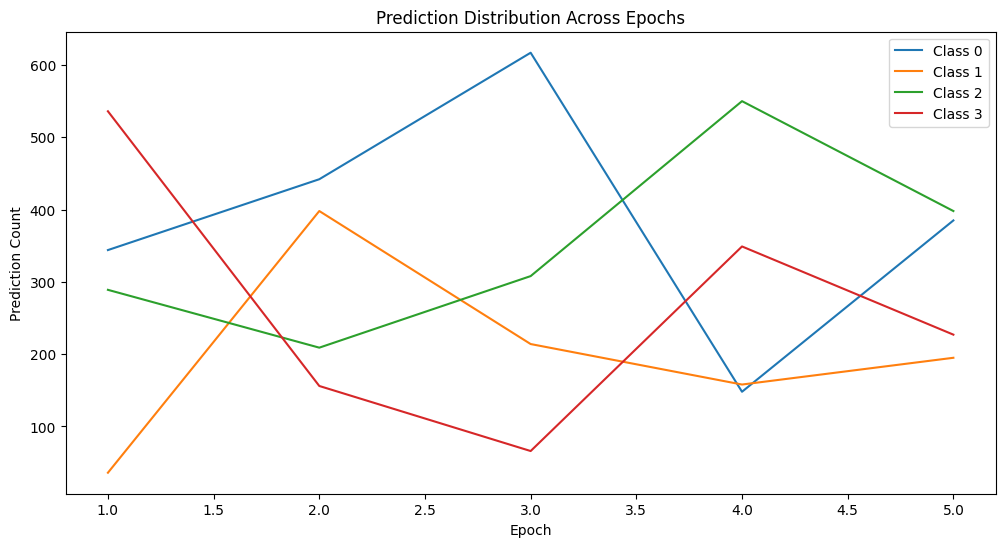


Overall Prediction Counts Across All Epochs: Counter({np.int64(0): 1936, np.int64(2): 1754, np.int64(3): 1334, np.int64(1): 1001})
Overall Accuracy Across All Epochs: 59.82%
All results have been successfully saved in the 'results/' directory.


In [ ]:
# Analyse and save predictions
analyze_predictions(vit_all_predictions, vit_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/vit_train_loss_list.npy', np.array(train_loss_list))
np.save('results/vit_test_loss_list.npy', np.array(test_loss_list))
np.save('results/vit_accuracy_list.npy', np.array(accuracy_list))
np.save('results/vit_epoch_times_list.npy', np.array(vit_mean_epoch_time))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/vit_all_predictions.pkl', 'wb') as f:
    pickle.dump(vit_all_predictions, f)

with open('results/vit_all_true_labels.pkl', 'wb') as f:
    pickle.dump(vit_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")



### Now we explore a second version of the ViT model where we unfreeze the last Transformation block.

Key extras about this model
 - Pre-trained Model: Like the first model, this one starts with a pre-trained Vision Transformer, but only the last transformer block and the classification head are unfrozen.
 - Fine-tuning: The last transformer block (blocks.11) and the normalization layers are unfrozen. This allows the model to adjust the more complex representations in the deeper layers of the transformer to fit your specific task.
 - (There are 12 transformer blocks in total)

In [ ]:
# # Load a pre-trained Vision Transformer model
vit_model_ft = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)  # Adjust 'num_classes' to your task

# Fine-tuning setup (assuming you want to unfreeze specific layers)
for name, param in vit_model_ft.named_parameters():
    if 'blocks.11' in name or 'norm' in name or 'head' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Add Dropout layer before final classification layer
vit_model_ft.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(vit_model_ft.head.in_features, 4)
)

vit_model_ft.to(device)
vit_model_ft.train()

# Print the model architecture
print(vit_model_ft)

# Optimizer setup with different learning rates for head and other layers
head_params = list(vit_model_ft.head.parameters())
other_params = [p for p in vit_model_ft.parameters() if p not in set(head_params)]

optimizer = Adam([
    {'params': head_params, 'lr': 0.001},
    {'params': other_params, 'lr': 0.0001}
])

# Scheduler setup if needed
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/5], Train Loss: 0.5380, Val Loss: 0.4213, Accuracy: 83.90%
Epoch [2/5], Train Loss: 0.1820, Val Loss: 0.1751, Accuracy: 94.27%
Epoch [3/5], Train Loss: 0.0863, Val Loss: 0.0838, Accuracy: 97.43%
Epoch [4/5], Train Loss: 0.0448, Val Loss: 0.1008, Accuracy: 97.43%
Epoch [5/5], Train Loss: 0.0331, Val Loss: 0.0845, Accuracy: 98.09%


In [ ]:
# Run training
vit_ft_train_loss_list, vit_ft_test_loss_list, vit_ft_accuracy_list, vit_ft_all_predictions, vit_ft_all_true_labels, vit_ft_epoch_times = run_training(
    vit_model_ft, train_loader_vit, test_loader_vit, optimizer, scheduler, criterion, num_epochs, device, fine_tuning=True
)

# Print the mean epoch time
vit_ft_mean_epoch_time = np.mean(vit_ft_epoch_times)
print(f"ViT (fine-tuned) epoch time: {vit_ft_mean_epoch_time:.2f} seconds")

Epoch 1 Prediction Counts: Counter({np.int64(1): 465, np.int64(2): 316, np.int64(3): 239, np.int64(0): 185})
Epoch 2 Prediction Counts: Counter({np.int64(1): 349, np.int64(2): 318, np.int64(3): 277, np.int64(0): 261})
Epoch 3 Prediction Counts: Counter({np.int64(1): 319, np.int64(2): 311, np.int64(3): 293, np.int64(0): 282})
Epoch 4 Prediction Counts: Counter({np.int64(1): 331, np.int64(2): 309, np.int64(3): 293, np.int64(0): 272})
Epoch 5 Prediction Counts: Counter({np.int64(1): 316, np.int64(2): 310, np.int64(3): 298, np.int64(0): 281})


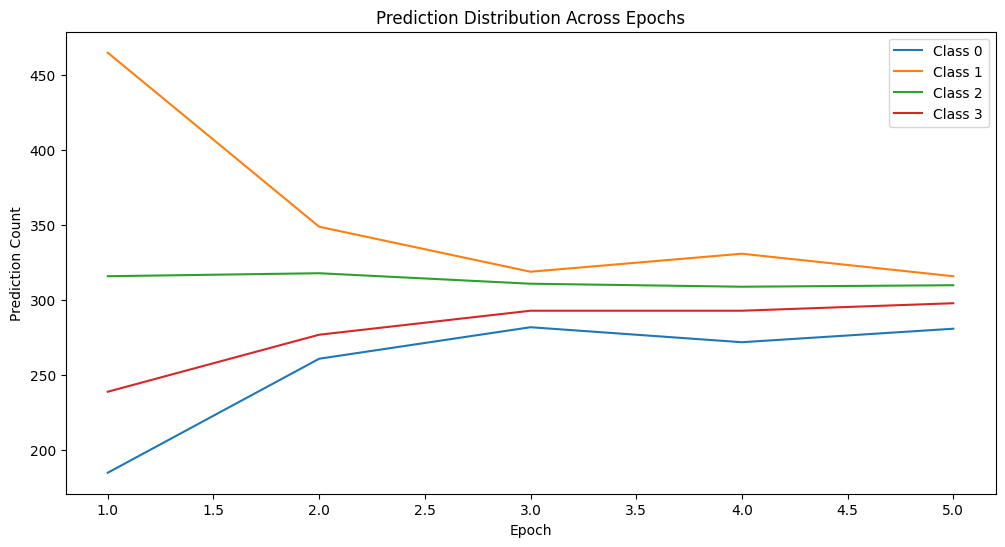


Overall Prediction Counts Across All Epochs: Counter({np.int64(1): 1780, np.int64(2): 1564, np.int64(3): 1400, np.int64(0): 1281})
Overall Accuracy Across All Epochs: 94.22%
All fine-tuned results have been successfully saved in the 'results/' directory.


In [ ]:
# Analyse and save results
analyze_predictions(vit_ft_all_predictions, vit_ft_all_true_labels)

# Save the lists as numpy arrays for easy reloading
np.save('results/vit_ft_train_loss_list.npy', np.array(vit_ft_train_loss_list))
np.save('results/vit_ft_test_loss_list.npy', np.array(vit_ft_test_loss_list))
np.save('results/vit_ft_accuracy_list.npy', np.array(vit_ft_accuracy_list))
np.save('results/vit_ft_epoch_times_list.npy', np.array(vit_ft_mean_epoch_time))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/vit_ft_all_predictions.pkl', 'wb') as f:
    pickle.dump(vit_ft_all_predictions, f)

with open('results/vit_ft_all_true_labels.pkl', 'wb') as f:
    pickle.dump(vit_ft_all_true_labels, f)

print("All fine-tuned results have been successfully saved in the 'results/' directory.")


In [ ]:
# !ls 'results/'

vit_accuracy_list.npy	  vit_ft_all_predictions.pkl  vit_ft_val_loss_list.npy
vit_all_predictions.pkl   vit_ft_all_true_labels.pkl  vit_test_loss_list.npy
vit_all_true_labels.pkl   vit_ft_test_loss_list.npy   vit_train_loss_list.npy
vit_ft_accuracy_list.npy  vit_ft_train_loss_list.npy


In [ ]:
import matplotlib.pyplot as plt

# Load the results
cnn_train_loss = np.load('results/cnn_train_loss_list.npy')
cnn_test_loss = np.load('results/cnn_test_loss_list.npy')
cnn_accuracy = np.load('results/cnn_accuracy_list.npy')

cnn_res_train_loss = np.load('results/cnn_res_train_loss_list.npy')
cnn_res_test_loss = np.load('results/cnn_res_test_loss_list.npy')
cnn_res_accuracy = np.load('results/cnn_res_accuracy_list.npy')

vit_train_loss = np.load('results/vit_train_loss_list.npy')
vit_test_loss = np.load('results/vit_test_loss_list.npy')
vit_accuracy = np.load('results/vit_accuracy_list.npy')

vit_ft_train_loss = np.load('results/vit_ft_train_loss_list.npy')
vit_ft_test_loss = np.load('results/vit_ft_test_loss_list.npy')
vit_ft_accuracy = np.load('results/vit_ft_accuracy_list.npy')

# Figure 1: Plot only CNN
fig1, (ax1_1, ax2_1) = plt.subplots(1, 2, figsize=(7, 4))  # Smaller figure size
plot_accuracy_results(cnn_train_loss, cnn_test_loss, cnn_accuracy, "CNN", ax1_1, ax2_1)
plt.tight_layout()
plt.show()

# Figure 2: Plot CNN and CNN with Residual Blocks
fig2, (ax1_2, ax2_2) = plt.subplots(1, 2, figsize=(7, 4))
plot_accuracy_results(cnn_train_loss, cnn_test_loss, cnn_accuracy, "CNN", ax1_2, ax2_2)
plot_accuracy_results(cnn_res_train_loss, cnn_res_test_loss, cnn_res_accuracy, "CNN Res", ax1_2, ax2_2)
plt.tight_layout()
plt.show()

# Figure 3: Plot CNN, CNN with Residual Blocks, and ViT
fig3, (ax1_3, ax2_3) = plt.subplots(1, 2, figsize=(7, 4))
plot_accuracy_results(cnn_train_loss, cnn_test_loss, cnn_accuracy, "CNN", ax1_3, ax2_3)
plot_accuracy_results(cnn_res_train_loss, cnn_res_test_loss, cnn_res_accuracy, "CNN Res", ax1_3, ax2_3)
plot_accuracy_results(vit_train_loss, vit_test_loss, vit_accuracy, "ViT", ax1_3, ax2_3)
plt.tight_layout()
plt.show()

# Figure 4: Plot CNN, CNN with Residual Blocks, ViT, and Fine-tuned ViT
fig4, (ax1_4, ax2_4) = plt.subplots(1, 2, figsize=(7, 4))
plot_accuracy_results(cnn_train_loss, cnn_test_loss, cnn_accuracy, "CNN", ax1_4, ax2_4)
plot_accuracy_results(cnn_res_train_loss, cnn_res_test_loss, cnn_res_accuracy, "CNN Res", ax1_4, ax2_4)
plot_accuracy_results(vit_train_loss, vit_test_loss, vit_accuracy, "ViT", ax1_4, ax2_4)
plot_accuracy_results(vit_ft_train_loss, vit_ft_test_loss, vit_ft_accuracy, "Fine-tuned ViT", ax1_4, ax2_4)
plt.tight_layout()
plt.show()


In [ ]:
# Load the epoch times for all models
cnn_epoch_times = np.load('results/cnn_epoch_times_list.npy')
cnn_res_epoch_times = np.load('results/cnn_res_epoch_times_list.npy')
vit_epoch_times = np.load('results/vit_epoch_times_list.npy')
vit_ft_epoch_times = np.load('results/vit_ft_epoch_times_list.npy')

# Figure 1: Plot only CNN epoch times
fig1, ax1 = plt.subplots(figsize=(7, 4))  # Smaller figure size
plot_epoch_times(cnn_epoch_times, "CNN", ax1)
plt.tight_layout()
plt.show()

# Figure 2: Plot CNN and CNN with Residual Blocks epoch times
fig2, ax2 = plt.subplots(figsize=(7, 4))
plot_epoch_times(cnn_epoch_times, "CNN", ax2)
plot_epoch_times(cnn_res_epoch_times, "CNN Res", ax2)
plt.tight_layout()
plt.show()

# Figure 3: Plot CNN, CNN with Residual Blocks, and ViT epoch times
fig3, ax3 = plt.subplots(figsize=(7, 4))
plot_epoch_times(cnn_epoch_times, "CNN", ax3)
plot_epoch_times(cnn_res_epoch_times, "CNN Res", ax3)
plot_epoch_times(vit_epoch_times, "ViT", ax3)
plt.tight_layout()
plt.show()

# Figure 4: Plot CNN, CNN with Residual Blocks, ViT, and Fine-tuned ViT epoch times
fig4, ax4 = plt.subplots(figsize=(7, 4))
plot_epoch_times(cnn_epoch_times, "CNN", ax4)
plot_epoch_times(cnn_res_epoch_times, "CNN Res", ax4)
plot_epoch_times(vit_epoch_times, "ViT", ax4)
plot_epoch_times(vit_ft_epoch_times, "Fine-tuned ViT", ax4)
plt.tight_layout()
plt.show()


In [ ]:
# If you want to download the results locally

import shutil
from google.colab import files

# Compress the 'results' folder into a zip file
shutil.make_archive('results', 'zip', 'results')

# Create a download link for the zip file
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>